# **AM 207**: Homework 3

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 24th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW3.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW3.tar.gz or AM207_YOURNAME_HW3.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Problem 1: Employee Satisfaction Improvement
This problem is going to explore the differences between complete pooling, unpooling and partial pooling for a normal model with observed standard deviations. 

You are working for a consulting firm which is trying to find a good strategy to improve employee satisfaction for their customers. Your company ran pilot studies in eight different customer companies and measured the improvement in employee satisfaction after the plan had been implemented for two years. The data you are given is the mean and standard deviation of the satisfaction improvement, measured by a survey. 
You follow the nature of your data by modeling the effect of the strategie with a normal model. To simplify things you can assume that the different standard deviations are an effect of different sample sizes, and that there is actually one underlying observation variance:

$$ \sigma_j^2 = \frac{\sigma^2}{n_j}$$

Thus the difference in the observed standard deviations in the survey results are caused by having different numbers of survey answers $n_j$. 

Discuss, create and compare three different solutions for your model using PYMC or another sampling method of your choice:

* complete pooling
* unpooling
* partial pooling

In [43]:
# Here is the data
data = np.double(np.array([[29.5,18.4],[6.3,12.7],[-3.9,15.9],[7.2,10.2],[-2.1,9.0],[1.8,12.1],[19.6,7.3],[12,18.6]]))
data_means = data[:,0]
data_std = data[:,1]

### Complete Pooling
The definition of the complete pooling is that one $\theta$ could generate all data. Also, the question states that standard deviation comes from global deviation. 

As such，in this problem, the mean value for each company $j$, I have:
$$\bar{Y_j} = \frac{1}{n_j}\sum_i^{n_j} Y_{ij} $$
And for the complete pooling here, I assume all groups(companies) share one mean model, $\theta$, coming from a normal distribution
$$P(\theta_j) \sim N(\theta_j,\sigma^2)$$

In this normal distribution, I fix $\theta$ and $\sigma$

 [-----------------100%-----------------] 100000 of 100000 complete in 3.7 secPlotting group_mean


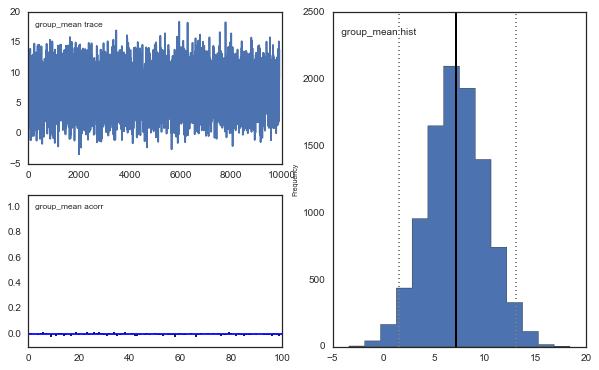

In [44]:
# my mean should comes from a fixed distribution
mu = 5
tau = 1.0/data_std ** 2
sigma = 0.05
group_means = pm.Normal("group_mean",mu,sigma)
likelihood = pm.Normal('likelihood', mu = group_means, tau=1.0/data_std ** 2, 
                        value = data_means, observed=True)
model = pm.Model([group_means, likelihood])
mc = pm.MCMC(model)
mc.sample(iter=100000, burn=1000, thin=10)
pm.Matplot.plot(group_means)

### Unpooling
In the case of unpooling, we treat each data points independent. As they all have their own $\theta$ generated by different models.

In this question, we have 8 models, which means we will generate 8 different means from different normal distributions. The code is below

 [-----------------100%-----------------] 100000 of 100000 complete in 28.8 secPlotting unp_mu_0
Plotting unp_mu_1
Plotting unp_mu_2
Plotting unp_mu_3
Plotting unp_mu_4
Plotting unp_mu_5
Plotting unp_mu_6
Plotting unp_mu_7


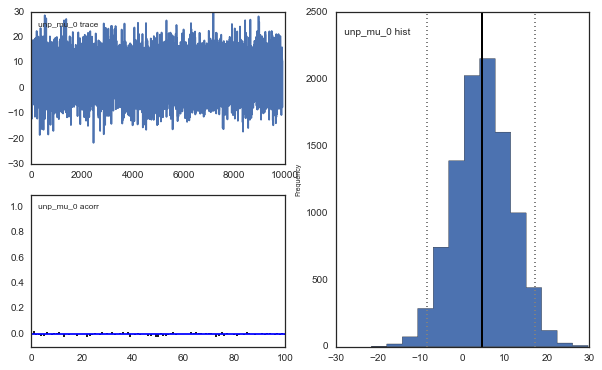

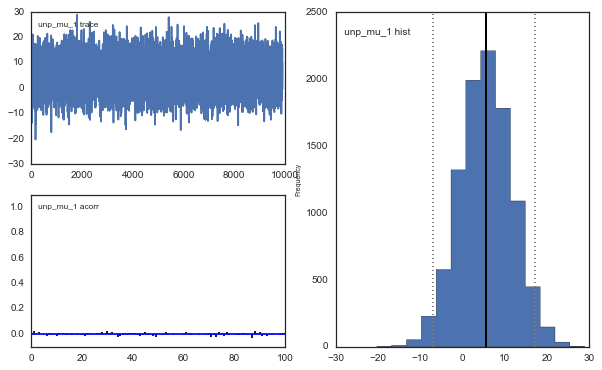

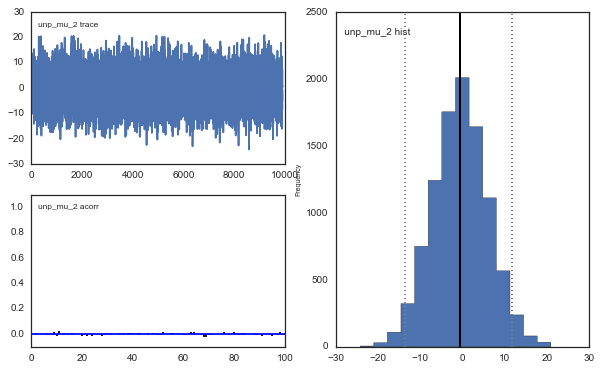

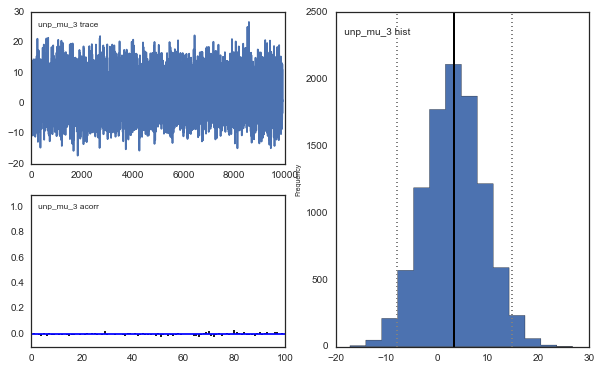

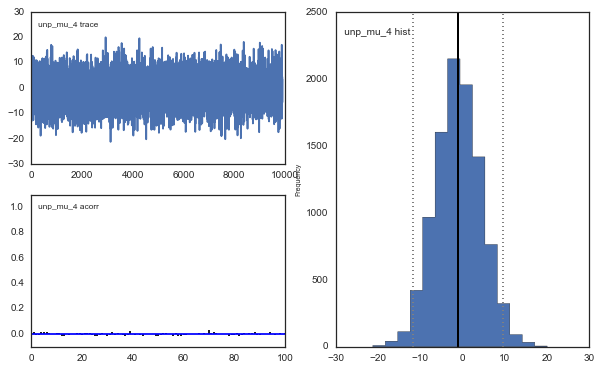

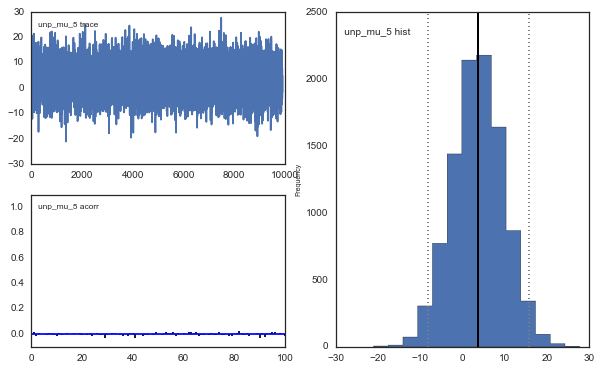

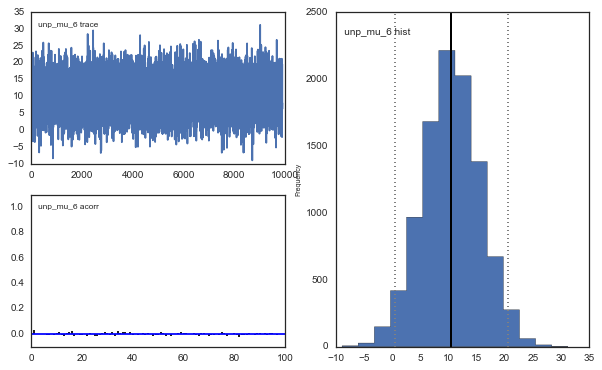

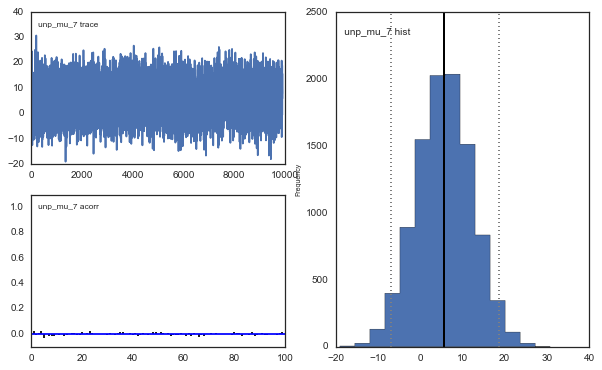

In [45]:
# We have eight companies
N = 8
# all of means should come from different situation
mu = scipy.stats.norm.rvs(2., 2., size=N).tolist()
# unpolling mu comes from different normal distribution
unp_mu=pm.Container([pm.Normal("unp_mu_%i" % i, mu[i], 0.02) for i in range(N)])

#generate likelihood
unp_likelihood = pm.Normal('likelihood', mu = unp_mu, tau=tau, 
                        value = data_means, observed=True)

#create posterior model
unp_model = pm.Model([unp_mu, unp_likelihood])
unp_mc = pm.MCMC(unp_model)
#generate sample from posterior
unp_mc.sample(iter=100000, burn=1000, thin=10)

#plot the trace
for i in range(N):
    pm.Matplot.plot(unp_mu[i])

### Partial Pooling

Partial Pooling actually is a good choice many times. As it gives freedom to those data points but also has some dependencies within those points. This corresponds to the real life's situation. In our case, to do partial pooling, those $\mu$ should be drawn from the same distribution.

 [-----------------100%-----------------] 100000 of 100000 complete in 29.2 secPlotting unp_mu_0
Plotting unp_mu_1
Plotting unp_mu_2
Plotting unp_mu_3
Plotting unp_mu_4
Plotting unp_mu_5
Plotting unp_mu_6
Plotting unp_mu_7


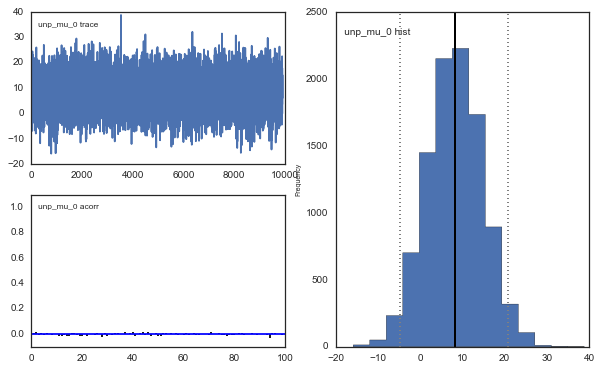

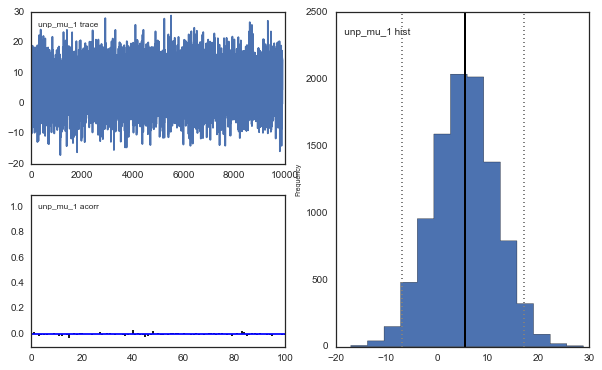

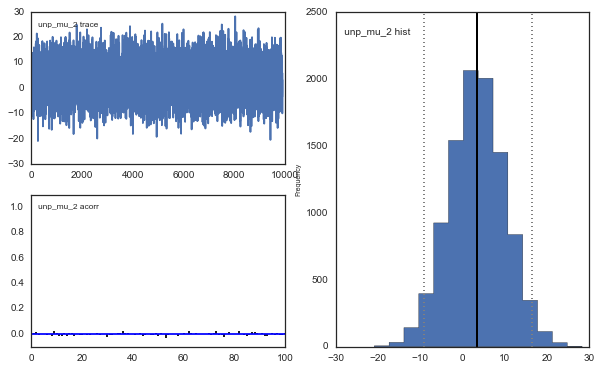

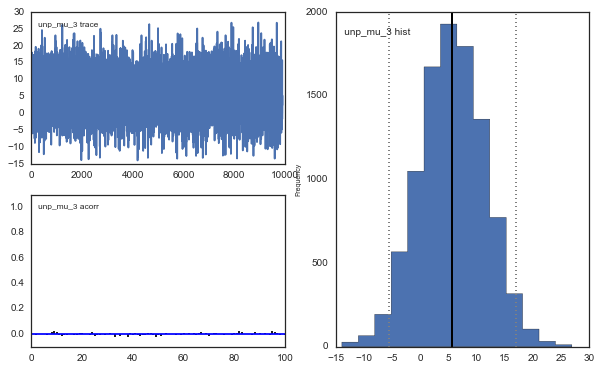

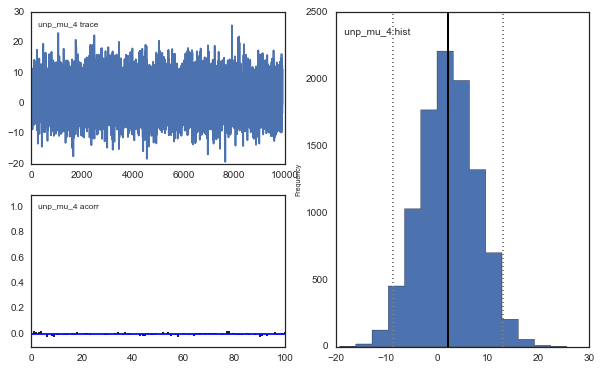

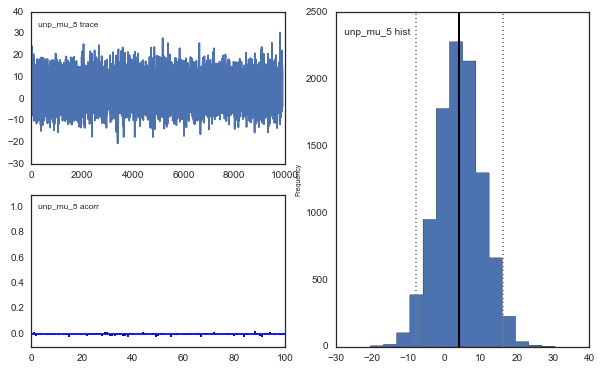

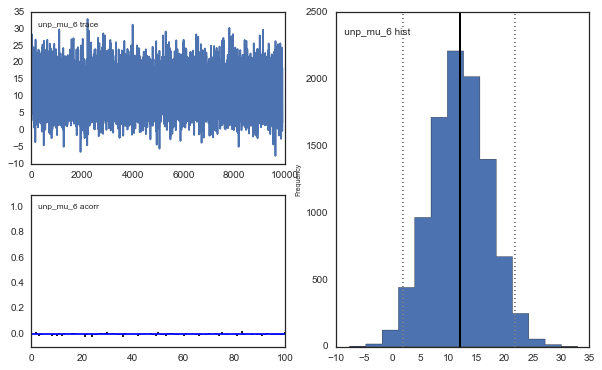

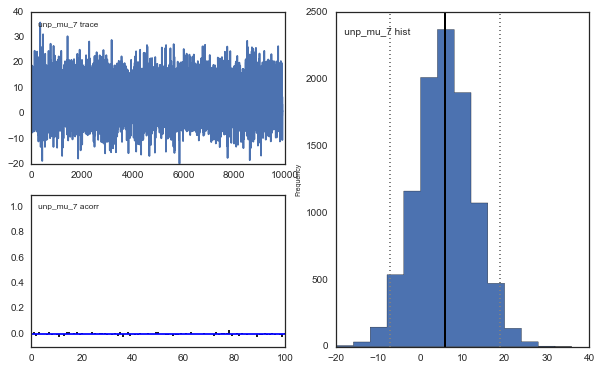

In [46]:
# This is Partial Pooling 

# We have eight companies
N = 8
# all of means should come from different situation
# unpolling mu comes from different normal distribution
unp_mu=pm.Container([pm.Normal("unp_mu_%i" % i,5, 0.02) for i in range(N)])

#generate likelihood
unp_likelihood = pm.Normal('likelihood', mu = unp_mu, tau=tau, 
                        value = data_means, observed=True)

#create posterior model
unp_model = pm.Model([unp_mu, unp_likelihood])
unp_mc = pm.MCMC(unp_model)
#generate sample from posterior
unp_mc.sample(iter=100000, burn=1000, thin=10)

#plot the trace
for i in range(N):
    pm.Matplot.plot(unp_mu[i])

### Conclusion for P1
In class, we talked about the differences and benefits for different pooling methods. As I have covered in the previous discussion, the differences is the dependencies within data points. For un-pooling, we assume there is no dependency at all; for complete pooling, however, we assume data points are fully dependent on each other. 

Why do we care about this? We have been covered in this class the benefits of having hierarchical model, which is stated as below:
 (a) it helps us develop a computational strategy to solve the problem, and (b) it allows estimates of the probabilities of any one of the units (here, one of the experiments) to borrow strength from all the data as a whole through the estimation of the hyperparameters. In other words, if some of the experiments had lower sample sizes or other outlier like behavior, the procedure helps "regularize" this.


# Problem 2: Motif Finding Using Gibbs

One interesting problem in bioinformatics is that of finding common subsequences of nucleotid bases (these subsequences are called motifs) that repeat themselves within larger DNA sequences. The problem is relevant for genetics because locating the positions of these motifs within the DNA sequence helps in the understanding of how genes are regulated.

Suppose that you are a biologist who is analyzing genetic material collected in a nearby asteroid. The DNA of this extraterrestrial form of life is formed as a sequence of $n_B = 5$ nucleotide bases. Let us label these extraterrestrial nucleotides and put them in a vector $\mathbf{b} = [\rm{M}, \rm{0}, \rm{2}, \rm{A}, \rm{7}]$. You have a DNA sample $\mathcal{S}$ consisting of $p=20$ sequences of DNA, each of them with a lenght $l=200$ nucleotide bases that you can find in <a href="HW3/Sequences_new.dat">this file</a>. Each row of the file is a DNA sequence. You are asked to find a motif of $q = 5$ consecutive nucleotides hidden in the background that appears to repeat itself very often in the DNA you were given, but that appears only once in each of the sequences.

Let us formalize the problem. The starting positions of the motif within each sequence (our missing data in the problem) can be represented by the set of random variables:

$$
\mathcal{A} = \left\{a_k, k = 1,...,p\right\}
$$

The motif has to start somewhere within the sequences and so for each sequence $\mathcal{S_k}$:

$$
\sum_{i=1}^{l}P(a_k=i) = 1
$$

What we are after is the joint distribution $P(\mathcal{A}|\mathcal{S})$ for the motif alignment (i.e., its starting position) being $a_k$ for sequence $\mathcal{S}_k$. As shown in [this paper](http://www.cs.cmu.edu/~epxing/Class/10810/readings/liu.pdf), for each sequence $\mathcal{S}_k$ (think of each sequence as a dimension of our parameter space) we can obtain the conditional probability: 

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

where $\mathcal{A_{\hat{k}}}$ refers to the alignments in all sequences other than $\mathcal{S}_k$, and $Z$ is a normalization factor. Of the other quantities, $s_x$ is a vector index for the *x-th* position in the sequence, with the same length as $\mathbf{\hat{\theta_j}}$ and $\mathbf{b}$. It takes a value of 1 at the entry that in $\mathbf{b}$ corresponds to the base at position $x$ and 0 for all other entries. Finally, vectors $\mathbf{\hat{\theta_j}}$ and $\mathbf{\hat{\theta_0}}$ contain respectively the probabilities of observing the $q$ bases at the corresponding position of the current sequence, and the probabilities of finding the same bases in the background. It is important to note that the power, division, and multiplication of vectors in the equation above is performed entry-wise.

Your only task is to design a Gibbs algorithm that samples the joint probability $P(\mathcal{A}|\mathcal{S})$. Your algorithm should converge and provide the alignments of the motif and the secret motif itself. Here are some hints/tasks that should help you and that will help the TF grading your homework:

(a) Describe the equation for the conditional probabilities in your own words, and make sure you understand it before you code anything. Be as explicit as possible.

(b) Start by assigning random starting positions for the $q$-long motif in all sequences. Then exclude a particular sequence $S_k$ (your current sequence) and use the remaining sequences to construct $\mathbf{\Theta}$ as a probability matrix from counting the number of times that the *i-th* base appears in position $j$ of the motif given the current alignments. Construct also a vector $\mathbf{\hat{\theta_0}}$ from counting the number of times that the *i-th* base appears in the background. Note that the vectors $\mathbf{\hat{\theta_j}}$ are the columns of matrix $\mathbf{\Theta}$.

(c) From $\mathbf{\Theta}$ and $\mathbf{\theta_0}$, derive the conditional probability over all possible alignments for your current sequence and draw a sample from it. This sample will be your updated alignment for the current sequence.

(d) Iterate over all $p$ sequences. Such iteration over sequences is only one Gibbs iteration. After enough Gibbs iterations you should start noticing that the algorithm has converged.


### Describe the equation
For the equation
$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$
The equation calculates the probability of having the ith position in the kth sequence as the first element of Motif 

$s_x$ is an index vector for the *x-th* position in the sequence,with the length of q, of which indicating the corresponding symbol inside the Motif Base. For example, if the xth position of the sequence is M, then $s_x=(1,0,0,0,0)$

Vector $\mathbf{\hat{\theta_j}}$ is the count of how many times the pattern shows up in the jth position, or contains respectively the probabilities of observing each entry in b at jth position of the motif. So we have a vector looks like this $(\theta_{M,j}, \theta_{0,j}, \theta_{2,j}. \theta_{A,j}, \theta_{7,j})$ where $\theta_{M,j}$ refers to the probability of observing M appears at jth position of the motif.

$\mathbf{\hat{\theta_0}}$ contains respectively the probabilities of observing each entry in b in the background. So we have a vector looks like this $(\theta_{M,0}, \theta_{0,0}, \theta_{2,0}. \theta_{A,0}, \theta_{7,0})$ where $\theta_{M,0}$ refers to the probability of observing M appears in the background.


In [2]:
# setup parameter
q=5 
p=20 
l=200
b=['M','0','2','A','7'] # bases
data = []
for line in open('HW3/Sequences_new.dat', 'r'):
    data.append(line)
print len(data)

20


In [17]:
# calculate the conditional probability for kth sequence
def calc_cond(motif_k, thetaj, theta_0):
    P = 1
    for j in range(5):
        ratio = thetaj[:,j] / theta_0
        s = np.zeros(5)
        if motif_k[j] == 'M':
            s[0] = 1
        elif motif_k[j] == '0':
            s[1] = 1
        elif motif_k[j] == '2':
            s[2] = 1
        elif motif_k[j] == 'A':
            s[3] = 1
        else:
            # in case we have totally different character
            s[4] = 1
        for i in range(5):
            if s[i] == 1:
                P *= ratio[i]
#         print P
    return P

In [25]:
# assign a random start position for all sequences
def gibbs_sampling(start, data, q, p, l, b):
    Res = []
    #Gibbs interations
    for k in range(p):
        # exclude a particular sequence S_k
        k_data = data[k]
        motif_k = k_data[start[k]:start[k]+5]
        bg = k_data[:start[k]] + k_data[start[k]+5:]     
        # Here I construct 19 sequences one by one 
        theta = np.zeros([5,5])
        theta0 = np.zeros(5)
        for seq in range(20):
            # I have to skip the kth one, very important
            if seq == k: 
                continue
            #construct motif and background   
            motif = data[seq][start[seq]:start[seq]+5]
            bg_no_k = data[seq][:start[seq]] + data[seq][start[seq]+5:]
            # construct THETA, with theta_j as columns
            for j in range(q):
            #for every q, construct theta_xj
                if motif[j] == 'M':
                    theta[0][j] += 1
                if motif[j] == '0':
                    theta[1][j] += 1
                if motif[j] == '2':
                    theta[2][j] += 1
                if motif[j] == 'A':
                    theta[3][j] += 1
                if motif[j] == '7':
                    theta[4][j] += 1
            #Constructing Theta_0 in all backfground
            for e in bg_no_k:
                if e == 'M':
                    theta0[0] += 1
                if e == '0':
                    theta0[1] += 1
                if e == '2':
                    theta0[2] += 1
                if e == 'A':
                    theta0[3] += 1
                if e == '7':
                    theta0[4] += 1
        # calculate the conditional probability
        prob = []
        for loop in range(196):
            prob.append(calc_cond(k_data[loop:loop+5],theta,theta0)) 
        # dont forget to normalized
        prob = prob / sum(prob)
        new_i = np.random.choice(l-4, 1, p=prob)[0]
        Res.append(new_i)
    return Res


In [36]:
# It seems not it's not always converges, so I have to try a couple of times
max_iter = 100
start = np.random.randint(0, 196, size = 20).tolist()
result = np.zeros((p, max_iter))
for i in range(max_iter):
    start =  gibbs_sampling(start=start, data=data, q=q, p=p, l=l, b=b)
    for j in range(p):
        result[j,i] = start[j]

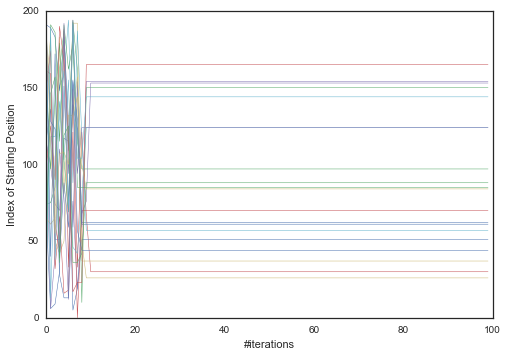

In [37]:
# check whether converge
for j in range(p):
    plt.plot(result[j], linewidth=0.5)
    plt.ylabel('Index of Starting Position')
    plt.xlabel('#iterations')

In [42]:
# After it gets converged, now I check what the Motif is. 
final = result[:,-1]
print "The final starting point is:",final
for i in range(p):
    a_i = int(final[i])
    print data[i][a_i:a_i+5]


The final starting point is: [  62.  150.   30.  153.   26.   57.   51.   97.   70.  154.   37.  124.
   61.   85.  165.  124.   84.  144.   44.   88.]
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207


### Conclusion for P2
The final Motif I found is AM207

# Problem 3: Optimizing Hand Luggage

You are going on a trip and have to optimize your hand luggage, but thanks to your cheap flight ticket, the weight of the hand lugagge is restricted and you are sure the airline will enforce the upper limit. You have a set of presents that you want to bring to the relatives you are visiting, but you have to notice that they don't all fit into your suitcase. 

This problem is also called the knapsack problem: given a set of items, each has its weight and value, determine which items should be included into your suitcase, so that the total weight does not exceed some value $W$ and the total value is maximal. The kind of the knapsack problem when each item can be included into the collection at most once is called the 0/1 knapsack problem. Your task is to solve this problem using simulated annealing. 

Implement simulated annealing to solve this problem with the list of items below. Which ones would you pick for your suitcase? Plot and discuss your optimization scheme and results. 
Compare your solution to a greedy algorithm, which sorts the items by the ratio $\frac{v_i}{w_i}$ and puts them into the suitcase consecutively.

In [47]:
# here is your data:

#number_of_data_points
N = 100

#total_weight_limit 
W = 3000

# weight of all the different items
w = np.array([  38,  236,  909,   73,  768,  906,  716,  646,  848,  961,  145,
        130,  973,  584,  750,  509,  391,  282,  179,  277,  255,  358,
        915,  469,  908,  253,  491,  669,  926,  399,  563,  581,  216,
        984,  754,  504,  479,  865,   87,  142,  394,    8,  320,  830,
        535,  314,  514,  897,  317,  210,  265,  729,  654,  628,  432,
        634,  457,  543,   72,  388,  455,  918,  562,  314,  516,  965,
        793,  498,   44,  589,   27,  821,  337,  622,  884,  298,  467,
         16,   65,  197,   26,  368,  739,  472,  904,  283,  666,  617,
         23,  778,  708, 1000,  127,  280,  382,  357,  156,  934,  314,
        596])

# value of all different items
v = np.array([36, 38, 30, 32, 40, 45, 45, 37, 49, 40, 44, 30, 31, 47, 43, 33, 30,
       43, 36, 50, 36, 32, 42, 41, 37, 43, 38, 41, 42, 41, 50, 34, 37, 37,
       43, 34, 46, 48, 30, 43, 40, 47, 37, 40, 50, 30, 42, 31, 39, 48, 49,
       31, 32, 42, 37, 32, 40, 30, 39, 48, 36, 32, 37, 37, 46, 45, 35, 47,
       40, 50, 46, 35, 43, 47, 48, 31, 50, 40, 30, 37, 30, 49, 47, 44, 43,
       50, 50, 41, 36, 43, 45, 39, 32, 37, 35, 34, 35, 38, 43, 47])


### Greedy Algorithm
In the greedy algorithm, I calculated the ratio $\frac{v_i}{w_i}$ and put them into the suitcase consecutively until the suitcase is full.

First of all, I put weights and values into dataframe and be prepared for further analysis. The result will be used for comparing our SA method.

In [48]:
# greedy algorithm
df = pd.DataFrame(w)
df.columns = ['weights']
df['values'] = v
df['ratios'] = v * 1.0/w * 1.0
#Here I sort by ratios
df_sorted = df.sort_values('ratios',ascending = False)
print df.head()
print df_sorted.head()

   weights  values    ratios
0       38      36  0.947368
1      236      38  0.161017
2      909      30  0.033003
3       73      32  0.438356
4      768      40  0.052083
    weights  values    ratios
41        8      47  5.875000
77       16      40  2.500000
70       27      46  1.703704
88       23      36  1.565217
80       26      30  1.153846


In [178]:
cucurry

Under naive method, the total weight  2806
and number of items I got are: 23
total values is 897


### Simulated Annealing

In this part, I delved into the method of simulated annealing. The result must be better than the greedy one.

In [50]:
df.head().values

array([[  3.80000000e+01,   3.60000000e+01,   9.47368421e-01],
       [  2.36000000e+02,   3.80000000e+01,   1.61016949e-01],
       [  9.09000000e+02,   3.00000000e+01,   3.30033003e-02],
       [  7.30000000e+01,   3.20000000e+01,   4.38356164e-01],
       [  7.68000000e+02,   4.00000000e+01,   5.20833333e-02]])

In [53]:
items = df.values
items.shape
start = df_sorted[:23].index.values.tolist()
print start

[41, 77, 70, 88, 80, 0, 68, 58, 78, 3, 38, 10, 39, 92, 11, 49, 96, 18, 79, 50, 19, 85, 32]


In [110]:
# the function to calculate values of items
# parameter is the items index [False, False, ..., True]
# return the value of item we chose
def itemsValues(list_index,value=v):
    return sum(list_index*value)

def itemsWeights(list_index,weight=w):
    return sum(list_index*weight)

In [118]:
import copy
def delitemsList(item_list,del_number):
    proposed_idx = copy.deepcopy(item_list)
    for i in range(del_number):
        # find a random idx in the items_list and take that one out 
        idx = np.random.randint(0,len(item_list))
        proposed_idx[idx] = False
    return proposed_idx

In [171]:
import copy
def additemsList(item_list,add_number):
    proposed_idx = copy.deepcopy(item_list)
    for i in range(add_number):
        new = np.random.randint(0,N)
        proposed_idx[new] = True
    return proposed_idx

In [172]:
# function for simulated annealing
# items: all items we could choose from
# init_temp: initial temperature 
# thermostat: linear factor to decrease the temperature 
# ftol, itol, otol: tolerance values for stopping 
# ftol: Not changing much anymore
# itol: maximum number of iterations
# otol: objective goal reached
# reannealing: schedule for reheating

def simulated_annealing(prev,items, init_temp, thermostat, ftol, itol, otol, reannealing):
    # ===============
    # SET THESE FOR DIAGNOSTICS
    # ================
    best = []
    m=10000     
    distsize=otol+1
    temperature = init_temp   
    N = items.shape[1]
    #number of accepted steps
    it = 0                    
    # Initialize my energy values
    # VALUES HERE IS OUR ENERGY 
    prev_E = itemsValues(prev)  
#     print "initial Energy(values) at start", prev_E
    
    #number of iterations
    atp=0
    
    didPlot = False
    while it >=0:
        # adaptive step size, here I imitate the in-class example to swap L items in the bag
        L = np.floor(np.sqrt(temperature)).astype(int)
        #This step is to add new points in neighbors
        propose_items = additemsList(prev,L)
        # Here check the items weights
        new_weight = itemsWeights(propose_items)
        # if the weight is too large, I will break it and propose new 
        # Here is my condition, loop if new_weight is larger than W
        while(new_weight > W):
            #take L out
            propose_items = delitemsList(propose_items,L)
            new_weight = itemsWeights(propose_items)
        # Here I know new_weight satisfies the condition
        # Now it's time to check the energy            
        new_E = itemsValues(propose_items)
        # Here I got my new_E 
        deltaE  =  new_E - prev_E 
        # if the new energy is larger, I will take it
        if new_E > prev_E:
            prev  = propose_items
            prev_E = new_E
            best.append(new_E)
            it = it+1
            atp += 1
        elif np.random.rand() < np.exp(deltaE/temperature):
            prev  = propose_items
            prev_E = new_E 
            best.append(new_E)
            it = it+1
            atp += 1


        if it % reannealing == 0:
            temperature = thermostat * temperature;
            compl_temp=0;
            if temperature < 0.01:
                temperature = 1
    
        if len(best)>m and np.std(best[-m:])/np.mean(best[-m:]) < ftol:
            print 'ftol'
            break
        if atp >itol:
            print 'itol'
            break
        if len(best)> 0 and best[-1] <= otol:
            print 'otol'
            print best[-1]
            break
    return best

In [173]:
# initialize the start
# They are all false
start = [False]*N
print "should be 100:", len(start)

should be 100: 100


In [176]:
best_results = simulated_annealing(start, items, 3.0, 0.9, 0.01, 100000, 0, 1000)

ftol


The best result is: 911


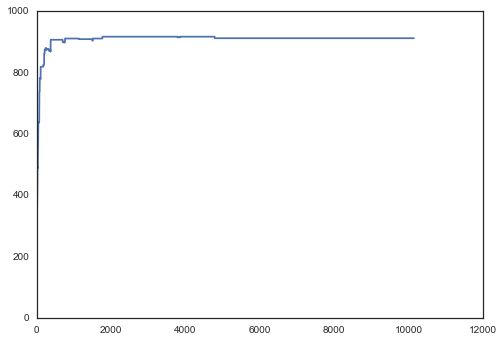

In [179]:
plt.plot(best_results)
print "The best result is:", best_results[-1]

### Conclusion for P3
After using SA, I noticed that my best situation is better than my greedy method. However, there is no much difference between two methods, though the greedy method takes much less time. 

# Problem 4: Confusing Classifications

You are a graduate student conducting research in image processing.  You want to test out your latest algorithm, which you decide to call "Ultra-Multilayer Hierarchical Super Convolutionary Neural Network."  However, in order to test out your algorithm, you need a sizable training data set. Luckly, your advisor has generously given you over 10 GB of over one million stock photos of cats and dogs.  Unfortunately, none of the images are labelled.  Fantastic!  You enjoy looking at photos of puppies and kittens in your spare time anyways so you decide to dedicate this entire weekend to labeling all of them. 

<table>
<tr>
 <td><img src="HW3/cat.jpeg" width=150>
 </td>
 <td><img src="HW3/dog.jpeg" width=150>
 </td>
</tr>
</table>

However, after spending two hours looking over hundreds of images, these puppies and kittens are no longer looking so cute.  In fact, you are starting to get disgusted at the idea of looking at another picture of these furry creatures.  

At this time, you decide to tap into the "power of the crowd" by farming out the labeling task to the workers of Amazon Mechanical Turk (MTurk). You decide to hire 3 MTurk workers.  However, you're not sure if these workers are reliable. So, how can you quantify the competency of the workers? In this problem you will develop a model to access the general difficulty of labeling the images of your two classes. 

Classifying items in general can be hard even for humans.  Some items just look alike, even if they actually are from two different classes. The difficulty in categorizing items of a specific class in relation to other classes is summarized by a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix):

$$ \Theta = \left( 
\begin{array}{cc}
1.0 & 0.0 \\
0.5 & 0.5
\end{array}
\right ) $$

This confusion matrix indicates that items of class 1 are very easy to classify, and always correctly labeled, whereas items of class 2 are very hard to classify and labels are basically just random guesses between the two possibilities. 

The models we discussed so far in homework and lecture were pretty low in dimensions. This problem is going to show you that the number of dimensions can grow very fast for some models, making a good sampling strategy crucial. We will only be able to explore a very minimal version of the problem, because of our limited computational resources, but it should be immediately clear how this model would scale for a greater number of classes, workers, and/or items.

Develop a Bayesian model that takes as input a set of (possible erroneous) item labelings and infer the underlying confusion matrix and the true label each data point. To make the model manageable by your laptop, use only one underlying confusion matrix (in principle different people could have different difficulties) two classes for the labels (the confusion matrix is 2x2), and a maximum of 150 data points. 

The model you are after is displayed in the following dependency graph:
<img src="HW3/confusion_model.png" alt="confusion matrix model" width=300>


$$\rho \sim Dir(\alpha) $$

$$z_i \sim Multinomial(\rho)$$

\begin{equation}
\Lambda = \begin{bmatrix}
 \lambda_1 \\
 \lambda_2 \\
\end{bmatrix}
\end{equation}

$$\Theta_{(k,:)} \sim Dir(\lambda_k)$$

$$r_{i,j} \sim Multinomial(\Theta_{(z_i , : )}), \ \forall j \in \{1,...,J\}$$

You're given reports generated by the 3 workers, so $r_{i,1}$ is one label for item $r_i$ and $r_{i,2}$ is another label given from another worker. Note that if the confusion matrix is not the identity matrix then these labels can be different because the workers make mistakes. The arrows in the diagram indicate dependence. So the labelings you observe are dependent on the confusion matrix $\Theta$ and the underlying true label $z_i$ for each item. $N$ is the number of data points you have and as described above you should use $N \leq 150$.

You can see from the diagram that the model uses Multinomials with Dirichlet priors. 

1. Start by describing the model in terms of these distributions, what they mean and what this arrangement means for the form of the labels $z_i$. Discuss the meaning and influence of the hyperparameter $\alpha$ on the true labels of the data.

2. Discuss your selection of the hyperparameter $\Lambda$ and how that influences the confusion matrix $\Theta$.

3. Implement this Bayesian model and sample from the posterior to recover the underlying confusion matrix $\Theta$ and the distribution of the true labels $\rho$.  Note: $\Theta$ is shared by all three workers.

### Credits
I referred the website reference: "http://alfan-farizki.blogspot.com/2015/07/pymc-tutorial-2-estimating-parameters.html" , got helps from TFs

### Analysis of this problem
The whole goal of the problem is to find the Confusion matrix, which is a representation of how hard to predict our data. In order to find the Confusion matrix, we need to try to use Maximum Likelihood Estimates then find each parameters.


Input: $r_{ij}$, labels given by the jth worker for the ith item

Output: $\Theta$, the confusion matrix


The graph given to us gives a clear idea of the whole hierarchical model. Before I got to that, it is worthy to notice that the conjugate Prior for multinomial distribution is Dirichlet Priors. In the end of the graph, we could find the hyper-parameters of the model, $\Sigma$ and $\alpha$. The $\Theta$ comes from the Dir(a), and our data is from the Prior of $\Theta$.

$Z_n$ : The true label of the nth object


### Basic Approach

The likelihood of our data can be represented(those data points are independent points), so the likelihood is the multiplications of single point, as follow

$$
P(r|\theta,z) = \prod_{n=0}^{150}\prod_{j=1}^{3} P(r|\theta,Z)
$$




### the selection of hyperparameter

During the lecture, Verena mentioned that our choices of hyperparameter could either based on our knowledge or just choose one that minimize our influence on data if we are ignorant about it.

In [18]:
# Here is your data

reports = np.load("HW3/reports.npy")

In [53]:
N = 150 
J = 3 # worksers
K = 2 # class
#choose 1 maybe to lower my influence 
alpha = np.ones(2)
#Here I create lambda 2 * 2, we have 2 classes here
lamb = np.ones((2,2)) 
lamb = [[1,1],[1,1]]
print lamb[0]

[1, 1]


In [54]:
# Model rho, rho is a conjugate prior - dirichlet
rho = pm.CompletedDirichlet('rho', pm.Dirichlet('rho_1',theta = alpha))


In [57]:
# copy from reference, as it stated, we could treat it as categorical
zi = pm.Container([pm.Categorical('z_{}'.format(i), p = rho, value = np.random.randint(0,2)) for i in range(150)])

In [58]:
# model theta, theta is dirichlet from two lambda. 
theta =pm.Container([pm.CompletedDirichlet('theta_1',pm.Dirichlet('theta1', theta = lamb[0])),
                     pm.CompletedDirichlet('theta_2',pm.Dirichlet('theta2', theta = lamb[1]))])

# we want to model r, input our datapoints
r = pm.Container([pm.Categorical("r_{}".format(i,j), 
                                 p = pm.Lambda("theta_{}".format(i),lambda zi = zi[i], theta = theta:theta[zi]),
                                 value = reports[i][j],
                                 observed = True) 
                  for i in range(N) for j in range(J)])

In [59]:
#now, let me create the model
model = pm.Model([rho,Theta,zi,r])
mcmc = pm.MCMC(model)
mcmc.sample(iter = 20000, burn = 1000, thin = 10)

 [-----------------100%-----------------] 20000 of 20000 complete in 1215.9 sec

Plotting rho_0_0
Plotting rho_0_1


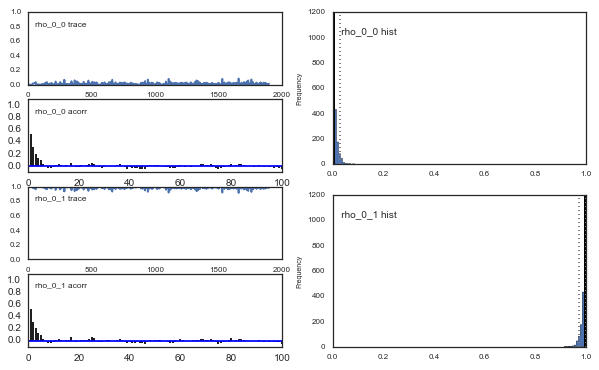

In [60]:
#now use pymc to plot rho
pm.Matplot.plot(rho)

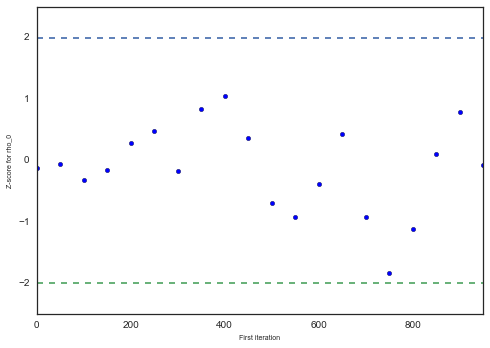

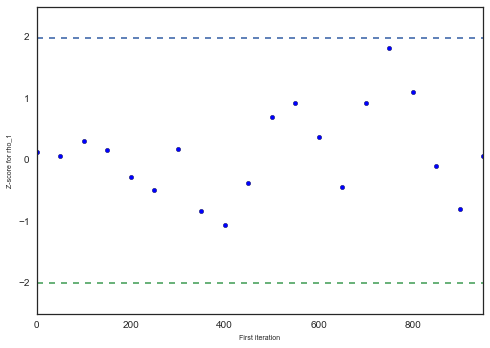

In [61]:
rho.trace()[:,0,1]
geweke_scores = pm.geweke(rho.trace()[:,0,0], first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "rho_0")
pm.Matplot.geweke_plot(pm.geweke(rho.trace()[:,0,1], first =0.1, last=0.5, intervals=20),'rho_1')

In [62]:
#the first row of confusion metrix
mcmc.trace("theta_c1")[-1]

array([[ 0.25906479,  0.74093521]])

In [63]:
#the second row of confusion matrix
mcmc.trace("theta_c2")[-1]

array([[ 0.50772217,  0.49227783]])

### The conclusion to P4
As such, the confuion matrix is [[0.25 0.74],[0.5 0.49]]